# Let's Train GPT-2



### Install Packages


In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout dev && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

In [2]:
from pathlib import Path
import sys

if is_colab():
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import jax
import optax
import jax.numpy as jnp
import numpy as np
from flax import nnx
import tiktoken

from jaxpt.dataloaders import DataLoader
from jaxpt.models import GPT2, GPTConfig
from jaxpt.train import train_step, parallel_train_step, accum_train_step, loss_fn, compute_global_norm
from jaxpt.infer import generate

### Configure compute

In [4]:
import os

# Hardware setup
print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

jax.config.update("jax_platform_name", "gpu") # Make sure we're using the GPU
#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
jax.config.update("jax_default_matmul_precision", "bfloat16") # Set the default precision for matrix multiplication

os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

def list_tpu_memory():
    devices = jax.devices()
    for device in devices:
        if 'TPU' in str(device.device_kind):
            print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

#list_tpu_memory()

print("Using device:", jax.default_backend())  # Should print 'gpu'

A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast

#%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Available devices: 1
Using device: cpu


### Initialize the GPT-2 model and perform a sanity check

In [ ]:
from functools import partial

import orbax.checkpoint as ocp

"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""
from datetime import datetime
import random
import string

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()
run_dir = f"run_{timestamp}_{random_code}"

checkpoint_dir = Path().absolute().parent / "checkpoints" 
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

def save_checkpoint(m, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(run_dir, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m = GPT2.from_checkpoint(checkpoint_path, rngs)
  return m


key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
config = GPTConfig(dtype=jnp.float32)
m = GPT2(config, rngs)
#m = load_checkpoint("run_20250310_krcksm", 199)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
nnx.display(state)

def generate_completions():
  m.eval()
  num_completions = 5
  max_length = 20
  generate_completion = partial(generate, m, max_length=max_length)
  prefix = "The clever jackal"
  enc = tiktoken.get_encoding('gpt2')
  tokens = enc.encode(prefix)
  tokens = jnp.array(tokens, dtype=jnp.int32)
  tokens = jnp.expand_dims(tokens, axis=0)
  x = jnp.tile(tokens, (num_completions, 1))


  x = generate_completion(x=x) # Make sure you can do a forward pass
  output = []
  for i in range(num_completions):
      tokens = x[i, :max_length].tolist()
      decoded = enc.decode(tokens)
      output.append(decoded)
  return output

completions = generate_completions()
for completion in completions:
  print(completion)


Checkpoint directory: /Users/vikram/dev/jaxpt/checkpoints


The clever jackal was  The elephant the that are a will no lion no right of come
The clever jackal — was be his gold," a saying it as is: not it at life
The clever jackal for I to will all at you, will, there his I do be a
The clever jackal this are king,"OSSDS dear my his again I his am of  is
The clever jackal said! they I not it him as, then with To f story


### Training setup

In [6]:
import dataclasses


@dataclasses.dataclass()
class TrainerConfig:
  num_tokens_per_batch: int = 2**19 # 2**18, 0.5 million as per the GPT 3.5 paper
  mB: int = 64
  T: int = 1024
  max_steps: int = 19073
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 100
  checkpoint_interval: int = 100
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


#trconf = TrainerConfig()
trconf = TrainerConfig(
  num_tokens_per_batch=2**8,
  mB=4,
  T=64,
  max_steps=200,
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=10,
  checkpoint_interval=30,
)
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


weight decay param count: 124,318,464
tokens/batch: 256
block size: 64
sub-batch size: 4
no. gradient accumulation steps: 1
effective batch size per device:  4
effective batch size: 4
max steps: 200


### DataLoader and Validation Setup



In [7]:

dataset = "panchatantra-ryder"

if is_colab():
    dataset_path = Path().absolute() / "jaxpt" / "src" / "jaxpt" / "datasets" / dataset / "processed"
else:
    if dataset == "fineweb-edu":
      dataset_path = "/home/ubuntu/gpt2-train/jaxpt/src/jaxpt/datasets/fineweb-edu/processed"
    elif dataset == "panchatantra-ryder":
      dataset_path = Path().absolute().parent / "src"/ "jaxpt" / "datasets" / dataset / "processed"
    else:
      raise ValueError(f"Dataset {dataset} not found")  

train_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=num_devices, label="train")
eval_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=1, label="valid", quiet=True)

def validate(m):
  valid_loss = 0.0
  eval_steps = 10
  for i in range(eval_steps):
    batch, targets = eval_dl()
    batch = np.squeeze(batch)
    targets = np.squeeze(targets)
    loss = loss_fn(m, batch, targets)
    valid_loss += loss
  valid_loss /= eval_steps
  return valid_loss

def evaluate(m):
  m.eval()
  completions =generate_completions()
  val_loss = validate(m)
  m.train()
  return val_loss, completions



dataloader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     4
block size:     64
device rank:    1
------------------------


### Let's train the model

0 | lr: 6.00e-05 | loss: 6.3592 | norm: 0.00 | time: 10200.17ms | tokens processed: 256 | tok/sec: 25.10


valid loss: 6.2503
The clever jackal must As is with. come at and: his's by; the For
The clever jackal at LYes's has was favor with it his aANT are favor from had
The clever jackal LTHE." L: but. And he I at'sively as L king
The clever jackal hisivelyANT me as a my of this Lively in not my by
The clever jackal myyou his- king he there all do of there, do, or at


1 | lr: 1.20e-04 | loss: 6.0676 | norm: 0.00 | time: 1570.49ms | tokens processed: 512 | tok/sec: 163.01
2 | lr: 1.80e-04 | loss: 5.6765 | norm: 0.00 | time: 864.51ms | tokens processed: 768 | tok/sec: 296.12
3 | lr: 2.40e-04 | loss: 6.1759 | norm: 0.00 | time: 1032.38ms | tokens processed: 1,024 | tok/sec: 247.97
4 | lr: 3.00e-04 | loss: 5.6031 | norm: 0.00 | time: 738.66ms | tokens processed: 1,280 | tok/sec: 346.58
5 | lr: 3.60e-04 | loss: 5.8004 | norm: 0.00 | time: 1242.36ms | tokens processed: 1,536 | tok/sec: 206.06
6 | lr: 4.20e-04 | loss: 5.8275 | norm: 0.00 | time: 761.34ms | tokens processed: 1,792 | tok/sec: 336.25
7 | lr: 4.80e-04 | loss: 6.0481 | norm: 0.00 | time: 618.43ms | tokens processed: 2,048 | tok/sec: 413.95
8 | lr: 5.40e-04 | loss: 5.4183 | norm: 0.00 | time: 1012.25ms | tokens processed: 2,304 | tok/sec: 252.90
9 | lr: 6.00e-04 | loss: 5.8250 | norm: 0.00 | time: 1128.50ms | tokens processed: 2,560 | tok/sec: 226.85
10 | lr: 6.00e-04 | loss: 5.8593 | norm: 0.00

valid loss: 6.6040
The clever jackal be the to is L masterss the belovedful:

He his has
The clever jackalus things not in for's again his says so and find they setDS by
The clever jackals: my things his I to and who of wise a your be there 
The clever jackal from Victor by on Rusty of And heart as who be in are you king find
The clever jackal findus from in a said the him? and And. kings, what did


31 | lr: 5.84e-04 | loss: 5.2604 | norm: 0.00 | time: 2316.09ms | tokens processed: 8,192 | tok/sec: 110.53
32 | lr: 5.82e-04 | loss: 5.5597 | norm: 0.00 | time: 1745.58ms | tokens processed: 8,448 | tok/sec: 146.66
33 | lr: 5.81e-04 | loss: 5.5713 | norm: 0.00 | time: 1087.51ms | tokens processed: 8,704 | tok/sec: 235.40
34 | lr: 5.79e-04 | loss: 5.3451 | norm: 0.00 | time: 798.68ms | tokens processed: 8,960 | tok/sec: 320.53
35 | lr: 5.77e-04 | loss: 5.2548 | norm: 0.00 | time: 1098.66ms | tokens processed: 9,216 | tok/sec: 233.01
36 | lr: 5.75e-04 | loss: 5.6388 | norm: 0.00 | time: 700.09ms | tokens processed: 9,472 | tok/sec: 365.67
37 | lr: 5.74e-04 | loss: 5.5002 | norm: 0.00 | time: 1629.16ms | tokens processed: 9,728 | tok/sec: 157.14
38 | lr: 5.72e-04 | loss: 5.8247 | norm: 0.00 | time: 617.78ms | tokens processed: 9,984 | tok/sec: 414.39
39 | lr: 5.70e-04 | loss: 5.7520 | norm: 0.00 | time: 3596.79ms | tokens processed: 10,240 | tok/sec: 71.17
40 | lr: 5.67e-04 | loss: 5.630

valid loss: 6.1299
The clever jackal who Now of is not king you the his two he have — a OF
The clever jackal no in in: is you man is they proverb in you night with for proverb
The clever jackal that; The of proverb again to, who not one of again by man.
The clever jackal by for do me him in. what's saying be this." and the they
The clever jackal all at be. the whole that at are was kings They, OF so


61 | lr: 5.10e-04 | loss: 5.4738 | norm: 0.00 | time: 1644.58ms | tokens processed: 15,872 | tok/sec: 155.66
62 | lr: 5.06e-04 | loss: 6.2569 | norm: 0.00 | time: 1040.73ms | tokens processed: 16,128 | tok/sec: 245.98
63 | lr: 5.03e-04 | loss: 5.8784 | norm: 0.00 | time: 1432.53ms | tokens processed: 16,384 | tok/sec: 178.70
64 | lr: 4.99e-04 | loss: 5.8930 | norm: 0.00 | time: 1330.09ms | tokens processed: 16,640 | tok/sec: 192.47
65 | lr: 4.96e-04 | loss: 6.2014 | norm: 0.00 | time: 652.04ms | tokens processed: 16,896 | tok/sec: 392.61
66 | lr: 4.92e-04 | loss: 6.0604 | norm: 0.00 | time: 590.84ms | tokens processed: 17,152 | tok/sec: 433.28
67 | lr: 4.89e-04 | loss: 5.8927 | norm: 0.00 | time: 998.21ms | tokens processed: 17,408 | tok/sec: 256.46
68 | lr: 4.85e-04 | loss: 6.6527 | norm: 0.00 | time: 629.33ms | tokens processed: 17,664 | tok/sec: 406.78
69 | lr: 4.81e-04 | loss: 6.1190 | norm: 0.00 | time: 1246.06ms | tokens processed: 17,920 | tok/sec: 205.45
70 | lr: 4.78e-04 | los

valid loss: 5.9517
The clever jackal my . FRIIs said or is a house you to certainRA, our
The clever jackalal he was said heral this in do was have or so of there said
The clever jackal you will. asked what certain to his certain with with that their: is a
The clever jackal be when some there they have you who said there — a this on But
The clever jackal; a came. I saying I power on they water.ENDS my you


91 | lr: 3.92e-04 | loss: 5.8540 | norm: 0.00 | time: 1276.48ms | tokens processed: 23,552 | tok/sec: 200.55
92 | lr: 3.88e-04 | loss: 5.7886 | norm: 0.00 | time: 606.80ms | tokens processed: 23,808 | tok/sec: 421.88
93 | lr: 3.83e-04 | loss: 6.1436 | norm: 0.00 | time: 1259.73ms | tokens processed: 24,064 | tok/sec: 203.22
94 | lr: 3.79e-04 | loss: 5.8257 | norm: 0.00 | time: 1095.72ms | tokens processed: 24,320 | tok/sec: 233.64
95 | lr: 3.74e-04 | loss: 5.8750 | norm: 0.00 | time: 1769.92ms | tokens processed: 24,576 | tok/sec: 144.64
96 | lr: 3.70e-04 | loss: 5.7214 | norm: 0.00 | time: 1204.03ms | tokens processed: 24,832 | tok/sec: 212.62
97 | lr: 3.66e-04 | loss: 5.3513 | norm: 0.00 | time: 1123.09ms | tokens processed: 25,088 | tok/sec: 227.94
98 | lr: 3.61e-04 | loss: 5.9916 | norm: 0.00 | time: 1765.07ms | tokens processed: 25,344 | tok/sec: 145.04
99 | lr: 3.57e-04 | loss: 6.9737 | norm: 0.00 | time: 707.83ms | tokens processed: 25,600 | tok/sec: 361.67
100 | lr: 3.52e-04 | 

valid loss: 5.8955
The clever jackal or THE the t to master THE OF For they my power day- Each
The clever jackal him." asked, L story a friend this as his crab made so king when
The clever jackaled with we have is made toaver a a their youaver from soaver
The clever jackal a crow made this by I their night my proverb," OF It for .
The clever jackal this will that you to: "THE have my hundred. Why, an lion


121 | lr: 2.59e-04 | loss: 5.7040 | norm: 0.00 | time: 1584.89ms | tokens processed: 31,232 | tok/sec: 161.53
122 | lr: 2.55e-04 | loss: 5.7821 | norm: 0.00 | time: 652.87ms | tokens processed: 31,488 | tok/sec: 392.12
123 | lr: 2.51e-04 | loss: 6.1099 | norm: 0.00 | time: 580.29ms | tokens processed: 31,744 | tok/sec: 441.16
124 | lr: 2.47e-04 | loss: 5.9277 | norm: 0.00 | time: 589.15ms | tokens processed: 32,000 | tok/sec: 434.53
125 | lr: 2.42e-04 | loss: 5.7964 | norm: 0.00 | time: 972.38ms | tokens processed: 32,256 | tok/sec: 263.27
126 | lr: 2.38e-04 | loss: 5.2824 | norm: 0.00 | time: 723.18ms | tokens processed: 32,512 | tok/sec: 353.99
127 | lr: 2.34e-04 | loss: 5.5253 | norm: 0.00 | time: 571.01ms | tokens processed: 32,768 | tok/sec: 448.33
128 | lr: 2.30e-04 | loss: 5.2554 | norm: 0.00 | time: 581.51ms | tokens processed: 33,024 | tok/sec: 440.23
129 | lr: 2.26e-04 | loss: 5.5909 | norm: 0.00 | time: 593.90ms | tokens processed: 33,280 | tok/sec: 431.05
130 | lr: 2.22e-04

valid loss: 5.7738
The clever jackal who the saying he is he when with a other wasaver?d that when
The clever jackal THE no all this out me from to master he not of my all," took
The clever jackal that a friend- How will this of King him not himings from so a
The clever jackal it that Victor your that is with day a the King- You t. so
The clever jackalRA so yourANT."be, if Victor; my king that, was to


151 | lr: 1.44e-04 | loss: 5.3919 | norm: 0.00 | time: 1595.19ms | tokens processed: 38,912 | tok/sec: 160.48
152 | lr: 1.41e-04 | loss: 5.5976 | norm: 0.00 | time: 892.81ms | tokens processed: 39,168 | tok/sec: 286.73
153 | lr: 1.38e-04 | loss: 5.3295 | norm: 0.00 | time: 1132.78ms | tokens processed: 39,424 | tok/sec: 225.99
154 | lr: 1.34e-04 | loss: 5.6989 | norm: 0.00 | time: 725.69ms | tokens processed: 39,680 | tok/sec: 352.77
155 | lr: 1.31e-04 | loss: 5.9296 | norm: 0.00 | time: 706.47ms | tokens processed: 39,936 | tok/sec: 362.36
156 | lr: 1.28e-04 | loss: 6.2686 | norm: 0.00 | time: 821.65ms | tokens processed: 40,192 | tok/sec: 311.57
157 | lr: 1.25e-04 | loss: 5.4115 | norm: 0.00 | time: 705.84ms | tokens processed: 40,448 | tok/sec: 362.69
158 | lr: 1.23e-04 | loss: 5.4600 | norm: 0.00 | time: 571.88ms | tokens processed: 40,704 | tok/sec: 447.65
159 | lr: 1.20e-04 | loss: 5.7815 | norm: 0.00 | time: 639.24ms | tokens processed: 40,960 | tok/sec: 400.47
160 | lr: 1.17e-0

valid loss: 5.7031
The clever jackal was  the am." FRI There said, is saying- or Victor to proverb
The clever jackal into all I that?" With from: as will is one out I me will
The clever jackal! But him in: It a proverb not I can you from king this,
The clever jackal himly again for all and then; In have their not be do And
The clever jackal," was me: And to the poor are that; "Where, after must


181 | lr: 7.32e-05 | loss: 5.7965 | norm: 0.00 | time: 1446.67ms | tokens processed: 46,592 | tok/sec: 176.96
182 | lr: 7.19e-05 | loss: 5.9272 | norm: 0.00 | time: 826.69ms | tokens processed: 46,848 | tok/sec: 309.67
183 | lr: 7.06e-05 | loss: 5.8262 | norm: 0.00 | time: 958.63ms | tokens processed: 47,104 | tok/sec: 267.05
184 | lr: 6.94e-05 | loss: 5.9845 | norm: 0.00 | time: 719.80ms | tokens processed: 47,360 | tok/sec: 355.65
185 | lr: 6.83e-05 | loss: 5.8972 | norm: 0.00 | time: 1152.28ms | tokens processed: 47,616 | tok/sec: 222.17
186 | lr: 6.72e-05 | loss: 5.5358 | norm: 0.00 | time: 620.69ms | tokens processed: 47,872 | tok/sec: 412.44
187 | lr: 6.62e-05 | loss: 5.6290 | norm: 0.00 | time: 580.16ms | tokens processed: 48,128 | tok/sec: 441.26
188 | lr: 6.53e-05 | loss: 5.7995 | norm: 0.00 | time: 593.99ms | tokens processed: 48,384 | tok/sec: 430.98
189 | lr: 6.45e-05 | loss: 5.8596 | norm: 0.00 | time: 802.88ms | tokens processed: 48,640 | tok/sec: 318.85
190 | lr: 6.37e-0

valid loss: 6.0030
completions: ['The clever jackal was  The elephant the that are a will no lion no right of come', 'The clever jackal — was be his gold," a saying it as is: not it at life', 'The clever jackal for I to will all at you, will, there his I do be a', 'The clever jackal this are king,"OSSDS dear my his again I his am of  is', 'The clever jackal said! they I not it him as, then with To f story']
The clever jackal was  The elephant the that are a will no lion no right of come
The clever jackal — was be his gold," a saying it as is: not it at life
The clever jackal for I to will all at you, will, there his I do be a
The clever jackal this are king,"OSSDS dear my his again I his am of  is
The clever jackal said! they I not it him as, then with To f story


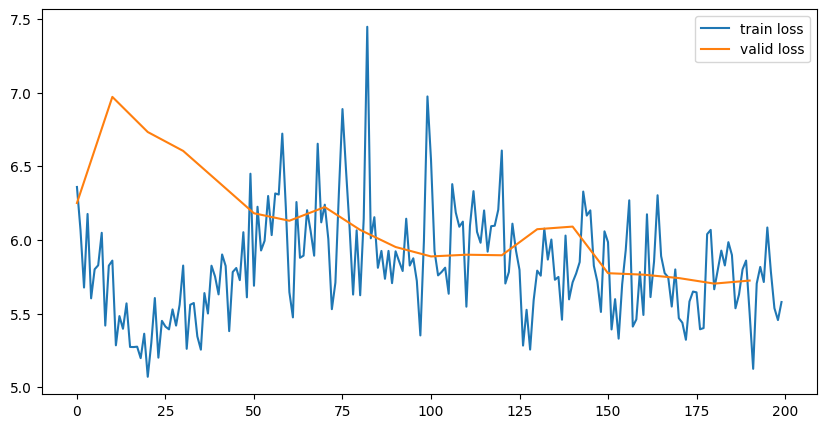

CPU times: user 21min 27s, sys: 5min 31s, total: 26min 59s
Wall time: 5min 28s


In [8]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt

from time import time
from functools import partial


import logging
import warnings
warnings.filterwarnings("ignore", message="Conversion for .*PmapSharding.*")
logging.getLogger("root").setLevel(logging.ERROR)

train_losses = []
val_losses = []

m.train()
try:
  for step in range(trconf.max_steps):
    start = time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    #avg_loss, avg_grads = train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = avg_loss[0]
    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss:0.4f} | norm: {norm:0.2f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}")
    if step % trconf.eval_interval == 0:
      valid_loss, completions = evaluate(m)
      val_losses.append((step, valid_loss))
      print(f"valid loss: {valid_loss:0.4f}"  )
      for completion in completions:
        print(completion)
    if step % trconf.checkpoint_interval == 0:
      save_checkpoint(m, step)
    

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")
valid_loss, completions = evaluate(m)
print(f"valid loss: {valid_loss:0.4f}")
print(f"completions: {completions}")
save_checkpoint(m, step)
for completion in completions:
  print(completion)
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
plt.legend()
plt.show()